Reading classics [Python Machine Learning 3rd Edition](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch15/ch15_part2.ipynb)

In [1]:
from IPython.display import display,HTML

c1,c2,f1,f2,fs1,fs2=\
'#11ff66','#6611ff','Wallpoet','Orbitron',20,10
def dhtml(string,fontcolor=c1,font=f1,fontsize=fs1):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family="""\
    +font+"""&effect=3d-float';</style>
    <h1 class='font-effect-3d-float' 
    style='font-family:"""+font+\
    """; color:"""+fontcolor+\
    """; font-size:"""+str(fontsize)+"""px;'>
    %s</h1>"""%string))

dhtml('Code Modules, Setting, & Functions')

In [2]:
!python3 -m pip install --upgrade pip \
--user --quiet --no-warn-script-location
!python3 -m pip install --upgrade tensorflow==2.3.0 \
--user --quiet --no-warn-script-location
!pip install mplcyberpunk --user --quiet

In [3]:
import warnings; warnings.filterwarnings('ignore')
import mplcyberpunk,numpy as np
import tensorflow as tf,pylab as pl
from IPython.core.magic import register_line_magic
from sklearn.metrics import \
classification_report,confusion_matrix
pl.style.use('cyberpunk')

@register_line_magic
def display_examples(pars):
    pars=pars.split()
    data,n=pars[0],int(pars[1])
    if data=='cats_vs_dogs':
        global cvd_test; data=cvd_test
    if data=='tf_flowers': 
        global flower_test; data=flower_test
    batch=next(iter(data.batch(n)))
    images=batch[0].numpy()
    labels=batch[1].numpy() 
    fig=pl.figure(figsize=(2*n//3,4.5))
    for i in range(n):
        ax=fig.add_subplot(3,n//3,i+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(images[i])
        ax.text(.85,.15,'{}'.format(labels[i]), 
                fontdict={'color':c1,'fontsize':30},
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
    pl.tight_layout(); pl.show()
    
@register_line_magic
def history_plot(yes):
    global history
    pl.figure(figsize=(10,10)); pl.subplot(211)
    keys=list(history.history.keys())[0:4]
    pl.plot(history.history[keys[0]],
            color=c1,label=keys[0])
    pl.plot(history.history[keys[2]],
            color=c2,label=keys[2])
    pl.xlabel('Epochs'); pl.ylabel('Loss')
    pl.legend(); pl.grid(); pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(history.history[keys[1]],
            color=c1,label=keys[1])
    pl.plot(history.history[keys[3]],
            color=c2,label=keys[3])
    pl.xlabel('Epochs'); pl.ylabel('Accuracy')    
    pl.legend(); pl.grid(); pl.title('Accuracy')
    mplcyberpunk.add_glow_effects()
    pl.tight_layout(); pl.show()
    
@register_line_magic
def display_reports(d):
    global model,model_weights,buffer_size
    c2,f2,fs2='#6611ff','Orbitron',12
    model.load_weights(model_weights)
    if d=='cats_vs_dogs': data=cvd_test
    if d=='tf_flowers': data=flower_test
    test_results=model.evaluate(
        data.batch(buffer_size),verbose=0)
    dhtml('\ntest accuracy: {:.2f}%'\
          .format(test_results[1]*100),c2,f2,fs2)
    batch=next(iter(data.batch(buffer_size)))
    y_test=batch[1].numpy()
    py_test=model.predict(data.batch(buffer_size))
    if d=='cats_vs_dogs':
        py_test=tf.sigmoid(py_test).numpy().round()
    if d=='tf_flowers':
        py_test=np.argmax(
            tf.nn.softmax(py_test).numpy(),axis=-1)
    py_test=py_test[:buffer_size]
    dhtml('Classification Report',c2,f2,fs2)
    print(classification_report(y_test,py_test))
    dhtml('Confusion Matrix',c2,f2,fs2)
    print(confusion_matrix(y_test,py_test))    

In [4]:
%%writefile tfpreprocess_dataimage.py
import warnings; warnings.filterwarnings('ignore')
import mplcyberpunk,tensorflow as tf,pylab as pl
import pandas as pd,numpy as np
import tensorflow_datasets as tfds
from IPython.display import display
pd.set_option('precision',3)
tf.keras.backend.set_floatx('float64')
tfds.disable_progress_bar()
pl.style.use('cyberpunk')

def get2img(file_name1,file_name2,
            file_path='../input/image-examples-for-mixed-styles/'):
    imgtf1=tf.image.decode_image(
        tf.io.read_file(file_path+file_name1))
    imgtf2=tf.image.decode_image(
        tf.io.read_file(file_path+file_name2))
    display(pd.DataFrame(
    [[str(imgtf1.numpy().shape),str(imgtf2.numpy().shape)],
     [imgtf1.numpy().dtype,imgtf2.numpy().dtype],
     [tf.rank(imgtf1).numpy(),tf.rank(imgtf2).numpy()]],
     index=['shape','dtype','rank'],columns=['flower','cat']))
    return imgtf1,imgtf2
def show2img(imgtf1,imgtf2,fig_size):
    pl.figure(figsize=(2*fig_size,fig_size))
    pl.subplot(1,2,1); pl.imshow(imgtf1)
    pl.subplot(1,2,2); pl.imshow(imgtf2)
    pl.tight_layout(); pl.show()
def bcrop(img,box):
    return tf.image.crop_to_bounding_box(
        img,box[0],box[1],box[2],box[3])
def ccrop(img,c):
    return tf.image.central_crop(img,c)
def hflip(img):
    return tf.image.flip_left_right(img)
def vflip(img):
    return tf.image.flip_up_down(img)
def bright(img,d):
    return tf.image.adjust_brightness(img,delta=d)
@tf.function
def preprocess(item,img_size,crop=.95,contrast=1.1):
    img,lbl=item['image'],item['label']
    img_cropped=tf.image.central_crop(img,crop)
    img_contrast=tf.image.adjust_contrast(
        img_cropped,contrast)
    img_resized=tf.image.resize(
        img_contrast,size=(img_size,img_size))
    img_flip=tf.image\
    .random_flip_left_right(img_resized)
    return (img_flip/255.,tf.cast(lbl,tf.int32))

Writing tfpreprocess_dataimage.py


In [5]:
%run tfpreprocess_dataimage.py
dhtml('Image Structure')

,flower,cat
shape,"(211, 282, 3)","(384, 216, 3)"
dtype,uint8,uint8
rank,3,3


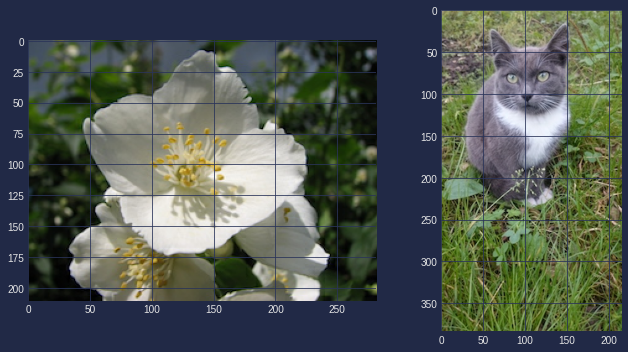

In [6]:
file_name1,file_name2='flower.png','cat.png'
imgtf1,imgtf2=get2img(file_name1,file_name2)
show2img(imgtf1,imgtf2,5)

In [7]:
dhtml('Image Processing')

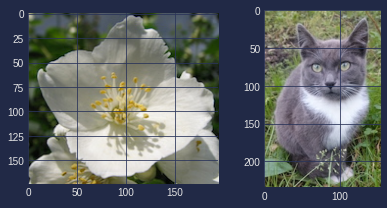

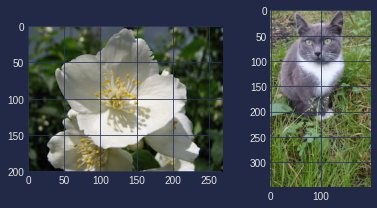

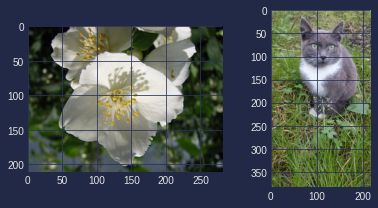

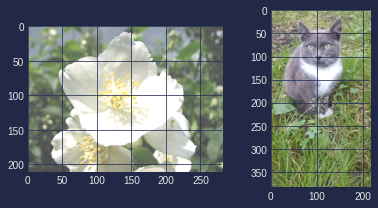

In [8]:
show2img(bcrop(imgtf1,[5,35,175,195]),
         bcrop(imgtf2,[5,15,235,155]),3)
show2img(ccrop(imgtf1,.95),ccrop(imgtf2,.91),3)
show2img(vflip(imgtf1),hflip(imgtf2),3)
show2img(bright(imgtf1,.3),bright(imgtf2,.1),3)

In [9]:
dhtml('Data Processing')

In [10]:
cvd=tfds.builder('cats_vs_dogs:4.0.0')
cvd.download_and_prepare()
split=['train[:80%]','train[80%:90%]','train[90%:]']
ds=cvd.as_dataset(shuffle_files=False,split=split)
img_size=64; buffer_size,batch_size=500,128
cvd_train=ds[0].map(
    lambda x: preprocess(x,img_size=img_size))
cvd_valid=ds[1].map(
    lambda x: preprocess(x,img_size=img_size))
cvd_test=ds[2].map(
    lambda x: preprocess(x,img_size=img_size))
ncvd_train=int(
    cvd.info.splits['train[:80%]'].num_examples)
dhtml(str(ncvd_train),c2,f2,fs2)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteFGFW7Q/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


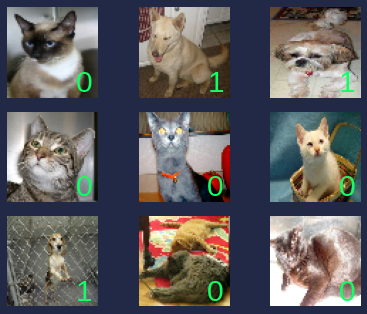

In [11]:
dhtml(cvd.info.features['image'],c2,f2,fs2)
dhtml(cvd.info.features['label'],c2,f2,fs2)
%display_examples cats_vs_dogs 9

In [12]:
cvd_train=cvd_train\
.shuffle(buffer_size=buffer_size).repeat()
cvd_train=cvd_train.batch(batch_size)
cvd_valid=cvd_valid.batch(batch_size)

In [13]:
flower=tfds.builder('tf_flowers')
flower.download_and_prepare()
split=['train[:80%]','train[80%:90%]','train[90%:]']
ds=flower.as_dataset(shuffle_files=False,split=split)
img_size2=128
flower_train=ds[0].map(
    lambda x: preprocess(x,img_size=img_size2))
flower_valid=ds[1].map(
    lambda x: preprocess(x,img_size=img_size2))
flower_test=ds[2].map(
    lambda x: preprocess(x,img_size=img_size2))
nflower_train=int(
    flower.info.splits['train[:80%]'].num_examples)
dhtml(str(nflower_train),c2,f2,fs2)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


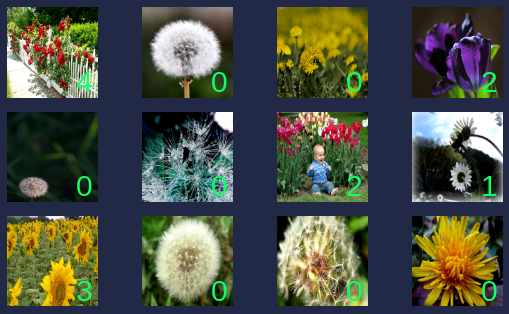

In [14]:
dhtml(flower.info.features['image'],c2,f2,fs2)
dhtml(flower.info.features['label'],c2,f2,fs2)
%display_examples tf_flowers 12

In [15]:
flower_train=flower_train\
.shuffle(buffer_size=buffer_size).repeat()
flower_train=flower_train.batch(batch_size)
flower_valid=flower_valid.batch(batch_size)

In [16]:
dhtml('CNN Model Building')

In [17]:
import warnings; warnings.filterwarnings('ignore')
import tensorflow as tf,numpy as np
import tensorflow.keras.layers as tkl
import tensorflow.keras.utils as tku
import tensorflow.keras.callbacks as tkc
tf.keras.backend.set_floatx('float64')
model_weights='/checkpoints'

def convblock(model,f,ks,dr):
    model.add(tkl.Conv2D(
    filters=f,kernel_size=(ks,ks),
    strides=(1,1),padding='same'))
    model.add(tkl.LeakyReLU(alpha=.02))
    model.add(tkl.MaxPool2D(pool_size=(2,2)))
    model.add(tkl.Dropout(dr))

def convblocks(img_size,conv,ks=5,dr=.2):
    model=tf.keras.Sequential()
    model.add(tkl.Input(
        (img_size,img_size,3),name='input'))
    for i in range(len(conv)):
        convblock(model,conv[i],ks,dr)
    return model

def complete_model(model,dense,num_classes,dr=.5):
    model.add(tkl.GlobalAveragePooling2D())   
    model.add(tkl.Dense(dense))
    model.add(tkl.LeakyReLU(alpha=.02))
    model.add(tkl.Dropout(dr))
    model.add(tkl.Dense(num_classes,activation=None))
    return model

def compile_model(model,loss):
    return model.compile(optimizer=tf.keras.optimizers.Adam(),
                         loss=loss,metrics=['accuracy'])

def cb(fw):
    early_stopping=tkc.EarlyStopping(
        monitor='val_loss',patience=10,verbose=2)
    checkpointer=tkc.ModelCheckpoint(
        filepath=fw,save_best_only=True,verbose=2,
        save_weights_only=True,monitor='val_accuracy',mode='max')
    lr_reduction=tkc.ReduceLROnPlateau(
        monitor='val_loss',verbose=2,patience=7,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [18]:
dhtml('CNN Binary Classification')

In [19]:
conv=[32,128,512]; num_classes=1
model=convblocks(img_size,conv)
dhtml('convblocks` outputs:  '+str(model.compute_output_shape(
    input_shape=(batch_size,img_size,img_size,3))))
model=complete_model(model,2048,num_classes)
dhtml('complete model`s outputs:  '+str(model.compute_output_shape(
    input_shape=(batch_size,img_size,img_size,3))))
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
compile_model(model,loss)

In [20]:
steps_per_epoch=np.ceil(ncvd_train/batch_size)
history=model.fit(
    cvd_train,epochs=50,shuffle=True, 
    validation_data=cvd_valid,
    callbacks=cb(model_weights),
    steps_per_epoch=steps_per_epoch)

Epoch 1/50
146/146 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.5278
Epoch 00001: val_accuracy improved from -inf to 0.48151, saving model to /checkpoints
146/146 [==============================] - 169s 1s/step - loss: 0.6866 - accuracy: 0.5278 - val_loss: 0.6841 - val_accuracy: 0.4815
Epoch 2/50
146/146 [==============================] - ETA: 0s - loss: 0.6646 - accuracy: 0.5474
Epoch 00002: val_accuracy improved from 0.48151 to 0.56191, saving model to /checkpoints
146/146 [==============================] - 167s 1s/step - loss: 0.6646 - accuracy: 0.5474 - val_loss: 0.6358 - val_accuracy: 0.5619
Epoch 3/50
146/146 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.6113
Epoch 00003: val_accuracy improved from 0.56191 to 0.62640, saving model to /checkpoints
146/146 [==============================] - 168s 1s/step - loss: 0.6274 - accuracy: 0.6113 - val_loss: 0.6008 - val_accuracy: 0.6264
Epoch 4/50
146/146 [==============================] 

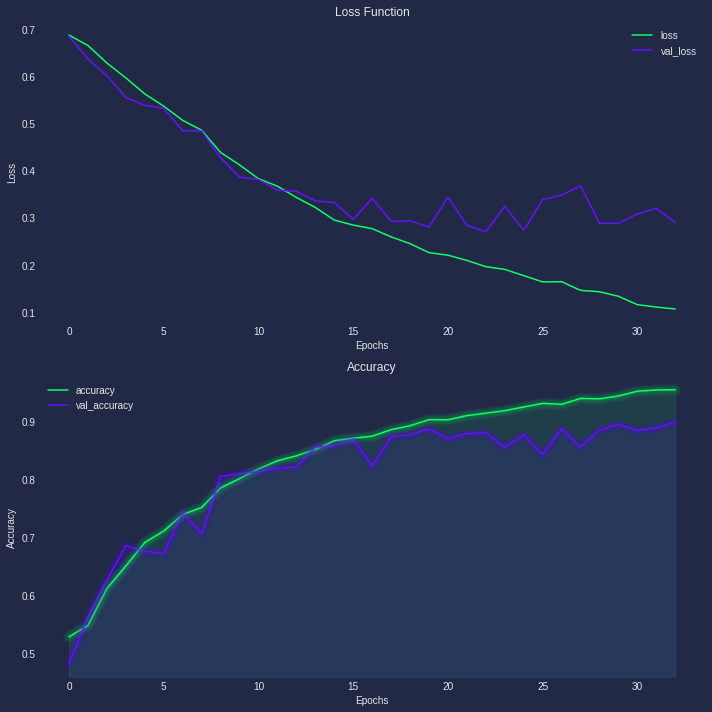

In [21]:
%history_plot yes

In [22]:
%display_reports cats_vs_dogs

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       256
           1       0.89      0.87      0.88       244

    accuracy                           0.89       500
   macro avg       0.89      0.89      0.89       500
weighted avg       0.89      0.89      0.89       500



[[231  25]
 [ 31 213]]


In [23]:
dhtml('CNN Classification')

In [24]:
conv2=[32,64,128,256,512]; num_classes2=5
model=convblocks(img_size2,conv2)
dhtml('convblocks` outputs:  '+str(model.compute_output_shape(
    input_shape=(batch_size,img_size2,img_size2,3))))
model=complete_model(model,4096,num_classes2)
dhtml('complete model`s outputs:  '+str(model.compute_output_shape(
    input_shape=(batch_size,img_size2,img_size2,3))))
loss=tf.keras.losses\
.SparseCategoricalCrossentropy(from_logits=True)
compile_model(model,loss)

In [25]:
steps_per_epoch=np.ceil(nflower_train/batch_size)
history=model.fit(
    flower_train,epochs=50,shuffle=True, 
    validation_data=flower_valid,
    callbacks=cb(model_weights),
    steps_per_epoch=steps_per_epoch)

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 1.5238 - accuracy: 0.2867
Epoch 00001: val_accuracy improved from -inf to 0.41689, saving model to /checkpoints
23/23 [==============================] - 30s 1s/step - loss: 1.5238 - accuracy: 0.2867 - val_loss: 1.3993 - val_accuracy: 0.4169
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.3577 - accuracy: 0.3971
Epoch 00002: val_accuracy improved from 0.41689 to 0.43052, saving model to /checkpoints
23/23 [==============================] - 26s 1s/step - loss: 1.3577 - accuracy: 0.3971 - val_loss: 1.3401 - val_accuracy: 0.4305
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.2426 - accuracy: 0.4518
Epoch 00003: val_accuracy improved from 0.43052 to 0.52316, saving model to /checkpoints
23/23 [==============================] - 26s 1s/step - loss: 1.2426 - accuracy: 0.4518 - val_loss: 1.1476 - val_accuracy: 0.5232
Epoch 4/50
23/23 [==============================] - ETA: 0s - loss:

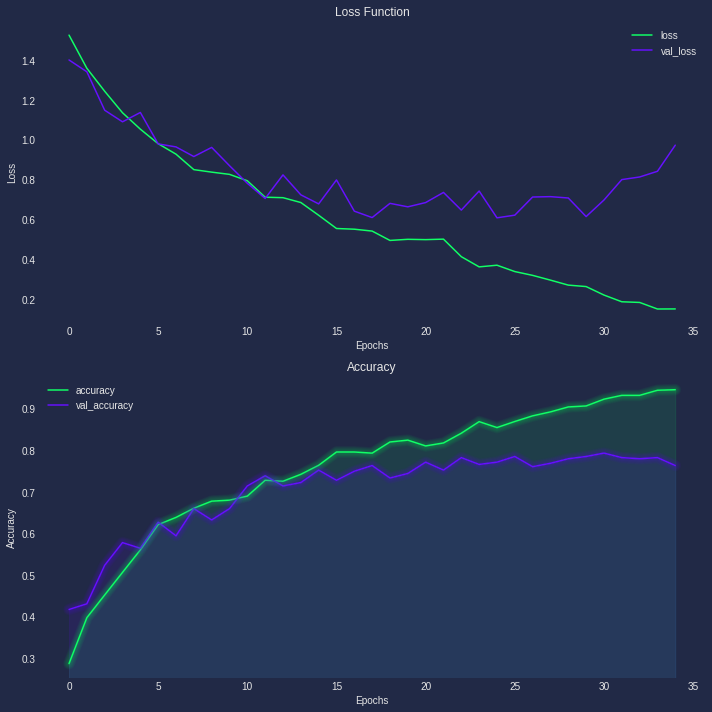

In [26]:
%history_plot yes

In [27]:
%display_reports tf_flowers

              precision    recall  f1-score   support

           0       0.86      0.96      0.91        70
           1       0.85      0.85      0.85        61
           2       0.79      0.81      0.80        85
           3       0.99      0.91      0.95        76
           4       0.79      0.75      0.77        75

    accuracy                           0.85       367
   macro avg       0.86      0.86      0.85       367
weighted avg       0.85      0.85      0.85       367



[[67  1  1  0  1]
 [ 3 52  2  0  4]
 [ 2  5 69  0  9]
 [ 3  2  1 69  1]
 [ 3  1 14  1 56]]
